# Subset high expression
Create a heatmap of mean expression forhighly ranked genes for different annotations

In [16]:
import scanpy as sc
import matplotlib.pyplot as plt
import sclitr as sl
import math
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import math
import anndata as ad

In [17]:
# Set font globally
plt.rcParams.update({
    'font.family': 'serif',           # Font family
    'font.serif': ['Arial'], # Specific font
})

In [ ]:
DATA_PATH = "/placodes/data"

In [19]:
subclustered= sc.read_h5ad(f"{DATA_PATH}/anndatas/reclustered_subset_doublets_removed.h5ad")

In [ ]:
annotations=pd.read_csv(f"{DATA_PATH}/annotations/Annotations_scRNA_clonal - subset.csv")

In [ ]:
annotations = annotations[["re_leiden_2", "annotation"]]

In [22]:
# Give annotation to subclusterd
mapping_dict = annotations.set_index('re_leiden_2')['annotation'].to_dict()
map_dict={}
for x in mapping_dict:
    map_dict[str(x)] = mapping_dict[x]
del mapping_dict
subclustered.obs['reannotation'] = subclustered.obs['re_leiden_2'].map(map_dict)


In [23]:
# Transfer lens
cluster = subclustered[subclustered.obs["re_leiden_2"]=="38"]
tmp_c=cluster[cluster[:,"Cryaa"].X>0].copy()
subclustered.obs.loc[tmp_c.obs_names, "reannotation"] = "Lens"

In [ ]:
# This gives you the actual expression values rather than differential expression
mean_expr = pd.DataFrame(
    subclustered.X.toarray() if hasattr(subclustered.X, 'toarray') else subclustered.X,
    columns=subclustered.var_names,
    index=subclustered.obs_names
)
mean_expr['group'] = subclustered.obs["reannotation"].values

# Get mean expression for each gene in each group
mean_per_group = mean_expr.groupby('group').mean()

# Get top N genes per group
n_top = 3
top_genes_per_group = {}
for group in mean_per_group.index:
    top_genes = mean_per_group.loc[group].sort_values(ascending=False).head(n_top)
    top_genes_per_group[group] = top_genes

# Create heatmap df for top genes per group
genes = []
for group in top_genes_per_group:
    for gene in top_genes_per_group[group].index.tolist():
        genes.append(gene)
to_df={}
for gene in genes:
    tmp_={}
    for group in top_genes_per_group:
        tmp_[group] = mean_per_group[gene][group]
    to_df[gene] = tmp_

df = pd.DataFrame(to_df)

df = df.T

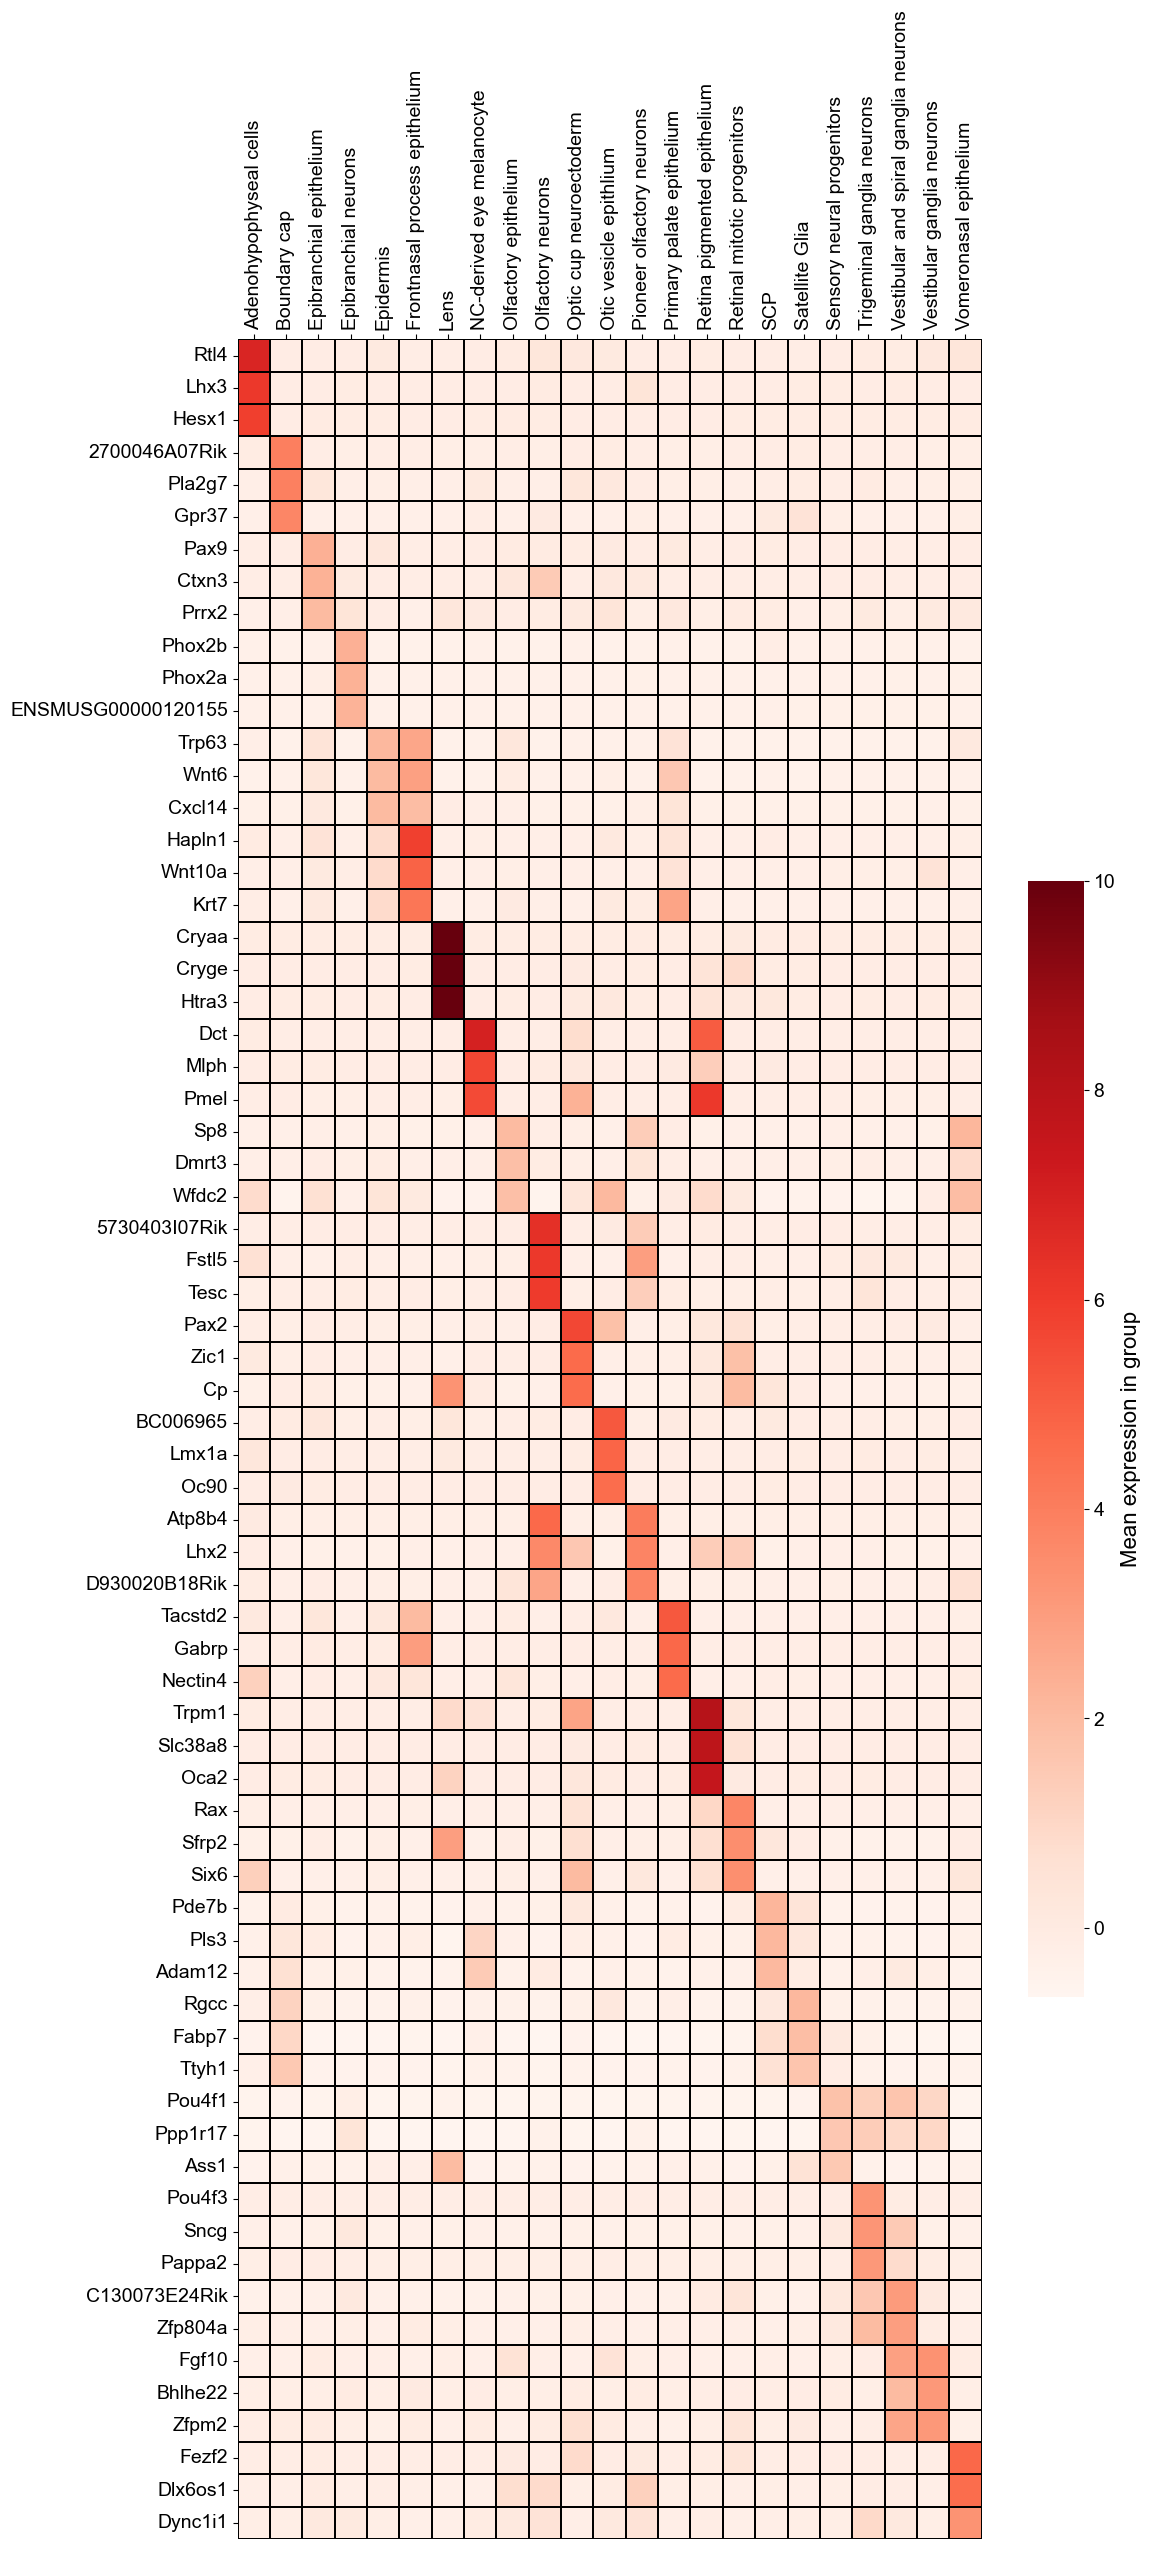

In [27]:
# Increase default font sizes
plt.rcParams.update({
        'font.size': 7,
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14
    })

fig, axes = plt.subplots(figsize=(12,29))

sns.heatmap(df,
            linewidths=0.01,
            linecolor='black',
            ax=axes,
            square=True,
            cbar_kws={'orientation': 'vertical', # Swtich if we transpose to horizontal/vertial
                      'location': 'right', # Swtich if we transpose to bottom/right
                      'label':'Mean expression in group',
                      "shrink":0.5
                  },
            cmap="Reds"
           )

# Adjust layout to prevent label cutoff
#plt.tight_layout()

cbar = axes.collections[0].colorbar  # Get the colorbar
cbar.set_label('Mean expression in group', size=16)  # Set label and size

axes.xaxis.tick_top()
plt.xticks(rotation=90)



# Save fig
plt.savefig("figures/subset_highest_mean_expression_group.svg", dpi=300, transparent=True)


plt.show()